In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.rcParams["figure.figsize"] = (6,3)

In [221]:
LEASE = -1
get_timestamp = lambda time_str: datetime.strptime(time_str, '%Y-%m-%d %H:%M:%S').timestamp()
epoch_2_ts = lambda timeseries: [datetime.fromtimestamp(x) for x in timeseries]

In [222]:
leases = pd.read_csv('inputs/lease_info.csv')
start_lease = get_timestamp(leases[leases['action'] == 'start'].iloc[0]['trace_time'])
end_lease = get_timestamp(leases[leases['action'] == 'start'].iloc[-1]['trace_time'])

In [223]:
(datetime.fromtimestamp(start_lease)), (datetime.fromtimestamp(end_lease))

(datetime.datetime(2018, 3, 14, 11, 42), datetime.datetime(2018, 7, 11, 9, 9))

In [224]:
def reshape_time(timeseries):
    delta = (end_lease - start_lease) / (timeseries[-1] - timeseries[0])
    results = []
    for i, t in enumerate(timeseries):
        if len(results) == 0:
            results.append(start_lease)
        else:
            results.append(int(results[i-1] + (t-timeseries[i-1])*delta))
    return results

In [225]:
def process_complete_leases(work_dir):
    completed_lease = pd.read_csv('%s/complete_leases.csv' % work_dir)
    completed_lease.dropna(inplace=True)
    completed_lease.sort_values(by=['Time'], inplace=True)
    start_time = completed_lease['Time'].iloc[0]
    end_time = completed_lease['Time'].iloc[-1]
    return start_time, end_time

In [226]:
def process_node_terminations(work_dir):
    _, end_time = process_complete_leases(work_dir)
    node_term = pd.read_csv('%s/node_terminations.csv' % work_dir)
    node_term.dropna(inplace=True)
    node_term.sort_values(by=['Time'], inplace=True)
    node_term = node_term[node_term['Time'].astype(int) <= int(end_time)]
    node_term['Time'] = reshape_time(node_term['Time'].to_list())
    node_term['Time'] = epoch_2_ts(node_term['Time'].to_list())
    node_term.set_index(['Time'], inplace=True)
    return node_term

In [227]:
def process_utilization_rate(work_dir):
    _, end_time = process_complete_leases(work_dir)
    ru = pd.read_csv('%s/utilization_rate.csv' % work_dir)
    ru.dropna(inplace=True)
    ru.sort_values(by=['Time'], inplace=True)
    ru = ru[ru['Time'].astype(int) <= int(end_time)]
    ru['Time'] = reshape_time(ru['Time'].to_list())
    ru['Time'] = epoch_2_ts(ru['Time'].to_list())
    ru = ru[(ru['Total Util Rate'] != 0)]
    ru.set_index(['Time'], inplace=True)
    return ru

In [228]:
def process_osg_jobs(work_dir):
    _, end_time = process_complete_leases(work_dir)
    osg_jobs = pd.read_csv('%s/osg_jobs.csv' % work_dir)
    osg_jobs = osg_jobs.dropna()
    osg_jobs = osg_jobs[osg_jobs['action'] == 'stop']
    # osg_jobs['JobSimCompleteDate'] = pd.to_datetime(osg_jobs['JobSimCompleteDate'])
    osg_jobs = osg_jobs[osg_jobs['JobSimCompleteDate'] <= int(end_time)]
    osg_jobs.sort_values(by=['JobSimCompleteDate'], inplace=True)
    osg_jobs = osg_jobs.dropna()
    del osg_jobs['_id']
    # outlier = osg_jobs['WastedCost'].quantile(0.999)
    # print(outlier)
    osg_jobs = osg_jobs[(osg_jobs['TotalCost'] > 0) & (osg_jobs['WastedCost'] >= 0)]
    return osg_jobs

# Baseline

In [229]:
work_dir = 'baseline'
start_time, end_time = process_complete_leases(work_dir)
ur_base = process_utilization_rate(work_dir)
ur_base.describe()

,Total Util Rate,Chameleon Utl Rate,OSG Utl Rate
count,3003.000000,3003.000000,3003.0
mean,24.771170,24.771170,0.0
std,16.424028,16.424028,0.0
min,0.364964,0.364964,0.0
25%,12.773723,12.773723,0.0
50%,22.456140,22.456140,0.0
75%,31.929825,31.929825,0.0
max,83.211679,83.211679,0.0


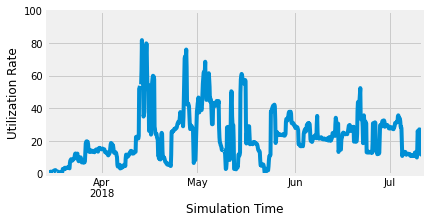

In [230]:
ur_base['Total Util Rate'].resample('3H').mean().plot()
plt.ylim(0, 100)
plt.xlabel('Simulation Time')
plt.ylabel('Utilization Rate')
plt.savefig('figs/exp1/utl_rate.png', dpi=500)

# Utilization Rate

random rolling_mean -0.9620060298175822
random rolling_median -0.4538554541247532
random lstm -1.2219326542252256
least_core rolling_mean -0.8420100404710528
least_core rolling_median -0.2174898553668756
least_core lstm -0.9959263297318116
least_resubmit rolling_mean -0.908173876276119
least_resubmit rolling_median -0.23494235609081263
least_resubmit lstm -0.9513242042442588
recent_deployed rolling_mean -0.4888646611729296
recent_deployed rolling_median -0.2929097671625364
recent_deployed lstm -1.1029765780176206


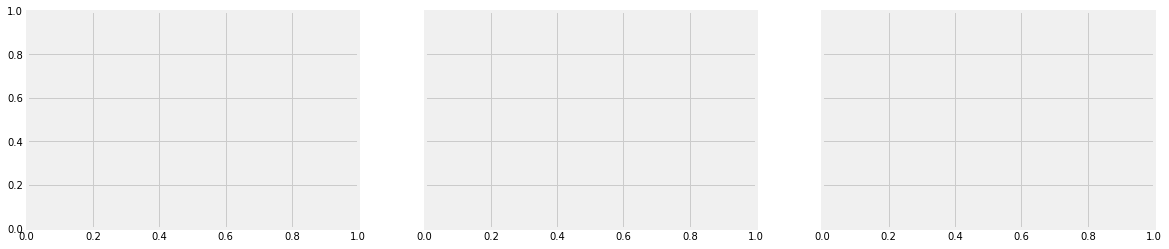

In [231]:
fig, axs = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(18, 4))
titles = ['Baseline', 'Rolling Mean', 'Rolling Median', 'LSTM']
labels = ['Random', 'Least-Core-Used', 'Least-Resubmit', 'Recent-Deployed']
colrs = ['r', 'g', 'b', 'c']

policies = ['random', 'least_core', 'least_resubmit', 'recent_deployed']
predictors = ['baseline-osg', 'rolling_mean', 'rolling_median', 'lstm']

def process_utilization_rate(work_dir):
    _, end_time = process_complete_leases(work_dir)
    ru = pd.read_csv('%s/utilization.csv' % work_dir)
    ru.dropna(inplace=True)
    ru = ru[ru['Time'].astype(int) <= int(end_time)]
    ru['Time'] = reshape_time(ru['Time'].to_list())
    ru['Time'] = epoch_2_ts(ru['Time'].to_list())
    # ru = ru[(ru['Total Util Rate'] != 0)]
    ru.set_index(['Time'], inplace=True)
    return ru

res_ur_base = ur_base['Total Util Rate'].resample('3H').mean()

for j, pol in enumerate(policies):
    baseline = None
    for i, pre in enumerate(predictors):
        work_dir = '%s/%s' % (pre, pol)
        ur = process_utilization_rate(work_dir)
        ur = ur.resample('3H').mean()
        node_term = process_node_terminations(work_dir).resample('3H').max()
        temp = node_term['unused terminations']
        temp = temp.iloc[1:].to_numpy() - temp[:-1].to_numpy()
        node_term = node_term.iloc[:-1]
        node_term['unused terminations'] = temp.tolist()
        node_term = node_term['unused terminations']
        ur = ur.iloc[:-1]
        utl_rate = 100*(ur['OSG Inuse'] + ur['Chameleon Inuse'] - node_term) / (ur['Chameleon Inuse'] + ur['OSG Inuse'] + ur['Chameleon Free'])
        if i == 0:
            baseline = utl_rate
        else:
            utl_rate_imp = (utl_rate - baseline)
            utl_rate_imp = utl_rate_imp.dropna()
            print(pol, pre, utl_rate_imp.mean())
            # utl_rate.plot(label='%s/%s' % (pre, pol))

            # axs[i-1].plot(utl_rate, label=labels[j])

#             count, bins_count = np.histogram(utl_rate_imp, bins=1000)
#             pdf = count / sum(count)
#             cdf = np.cumsum(pdf)
#             temp = np.array(bins_count[1:])
#             # print(pol, pre, cdf[np.where(temp>0)[0][0]])
#             axs[i-1].plot(bins_count[1:], cdf, label=labels[j])

#             pos = np.where(temp>=0)[0][0]
#             axs[i-1].scatter(bins_count[1:][pos], [cdf[pos]], marker='o', s=200)
#             axs[i-1].set_title(titles[i], fontsize=20)
#             axs[i-1].set_ylabel('CDF', fontsize=20)
#             # axs[i-1].set_xlabel('Resource Utilization Rate Difference Relative to Baseline', fontsize=20)
#             # axs[i-1].legend(loc='best', fontsize=14)
#             axs[i-1].tick_params(axis='both', which='major', labelsize=20)
#             axs[i-1].tick_params(axis='both', which='minor', labelsize=20)

# axs[i-1].legend(bbox_to_anchor=(1.05, 0.3), loc='lower left', borderaxespad=0., fontsize=20, ncol=1)

# fig.supxlabel('Resource Utilization Rate Difference Relative to Baseline', fontsize=25)
# fig.tight_layout()
# plt.savefig('figs/exp2/utl_imp.png', dpi=500)

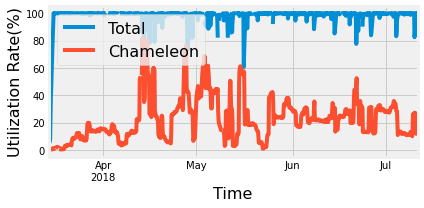

In [232]:
titles = ['Baseline', 'Rolling Mean', 'Rolling Median', 'LSTM']
labels = ['Random', 'Least-Core-Used', 'Least-Resubmit', 'Recent-Deployed']

policies = ['random', 'least_core', 'least_resubmit', 'recent_deployed']
predictors = ['baseline-osg', 'rolling_mean', 'rolling_median', 'lstm']

def process_utilization_rate(work_dir):
    _, end_time = process_complete_leases(work_dir)
    ru = pd.read_csv('%s/utilization.csv' % work_dir)
    ru.dropna(inplace=True)
    ru = ru[ru['Time'].astype(int) <= int(end_time)]
    ru['Time'] = reshape_time(ru['Time'].to_list())
    ru['Time'] = epoch_2_ts(ru['Time'].to_list())
    # ru = ru[(ru['Total Util Rate'] != 0)]
    ru.set_index(['Time'], inplace=True)
    return ru

res_ur_base = ur_base['Total Util Rate'].resample('3H').mean()
baseline = None
for i, pre in enumerate(predictors[2:3]):
    for j, pol in enumerate(policies[3:]):
        work_dir = '%s/%s' % (pre, pol)
        ur = process_utilization_rate(work_dir)
        ur = ur.resample('3H').mean()
        node_term = process_node_terminations(work_dir).resample('3H').max()
        temp = node_term['unused terminations']
        temp = temp.iloc[1:].to_numpy() - temp[:-1].to_numpy()
        node_term = node_term.iloc[:-1]
        node_term['unused terminations'] = temp.tolist()
        node_term = node_term['unused terminations']
        ur = ur.iloc[:-1]
        utl_rate = 100*(ur['OSG Inuse'] + ur['Chameleon Inuse'] - node_term) / (ur['Chameleon Inuse'] + ur['OSG Inuse'] + ur['Chameleon Free'])
        utl_rate.plot(label='Total')

ur_base['Total Util Rate'].resample('3H').mean().plot(label='Chameleon')
plt.ylabel('Utilization Rate(%)', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.legend(loc='best', fontsize=16)
plt.tight_layout()
plt.savefig('figs/exp2/utl.png', dpi=3000)

# Energy Consumption

In [233]:
df = []
for i, pre in enumerate(predictors):
    temp = []
    for j, pol in enumerate(policies):
        work_dir = '%s/%s' % (pre, pol)
        
        osg_jobs = process_osg_jobs(work_dir)
        wasted_cost = 100*(osg_jobs['WastedCost']/osg_jobs['TotalCost']).sum()/osg_jobs.shape[0]
        temp.append(wasted_cost)
    df.append(temp)

/Users/zhuangweikang/Library/Python/3.7/lib/python/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/zhuangweikang/Library/Python/3.7/lib/python/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/zhuangweikang/Library/Python/3.7/lib/python/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [234]:
df

[[4.636858185547572,
  3.6916871867797205,
  3.879766982688283,
  2.9534285923664427],
 [5.571685174309026, 4.590291383613099, 4.535842662539703, 2.619589205187555],
 [4.161082125802297,
  3.8535049821938605,
  4.538686389279875,
  2.0852019024503865],
 [6.052002967031102, 4.995678594696437, 5.007696557750138, 2.7063814999520144]]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Users/zhuangweikang/Library/Python/3.7/lib/python/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/panda

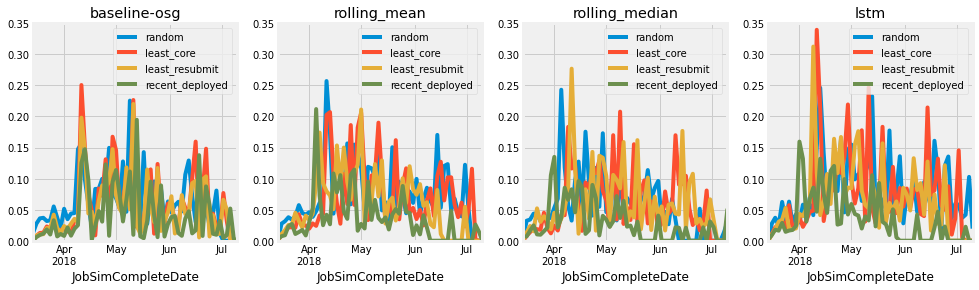

In [235]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
titles = ['Baseline', 'Rolling Mean', 'Rolling Median', 'LSTM']
labels = ['Random', 'Least-Core-Used', 'Least-Resubmit', 'Recent-Deployed']

for i, pre in enumerate(predictors):
    temp = []
    for j, pol in enumerate(policies):
        work_dir = '%s/%s' % (pre, pol)
        
        # wasted_cost = 100*(osg_jobs['WastedCost']/osg_jobs['TotalCost']).sum()/osg_jobs.shape[0]

        osg_jobs = process_osg_jobs(work_dir)
        osg_jobs['JobSimCompleteDate'] = reshape_time(osg_jobs['JobSimCompleteDate'].to_list())
        osg_jobs['JobSimCompleteDate'] = epoch_2_ts(osg_jobs['JobSimCompleteDate'].to_list())
        osg_jobs.set_index(['JobSimCompleteDate'], inplace=True)

        wc = osg_jobs[['WastedCost', 'TotalCost']]
        wc = wc.resample('48H').sum()
        # wc = wc.iloc[:120]
        wc.index = pd.to_datetime(wc.index)
        # print(pre, pol, wc.shape)
        (wc['WastedCost']/wc['TotalCost']).plot(ax=axs[i], label=pol)
        # axs[i].scatter(wc.index, wc['WastedCost']/wc['TotalCost'], marker='.')
        
        # temp.append(wasted_cost)
    axs[i].set_ylim(top=0.35, bottom=0)
    axs[i].set_title(pre)
    axs[i].legend()
    # df.append(temp)


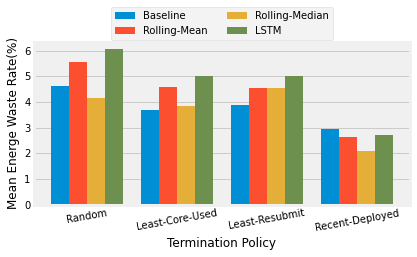

In [236]:
x = np.arange(4)
total_width, n = 0.8, len(policies)
width = total_width / n

plt.xticks(x, policies, rotation=10)
x = x - (total_width - width) / 2

plt.bar(x, df[0], label='Baseline', width=width)
plt.bar(x+width, df[1], label='Rolling-Mean', width=width)
plt.bar(x+2*width, df[2], label='Rolling-Median', width=width)
plt.bar(x+3*width, df[3], label='LSTM', width=width)

labels = ['Random', 'Least-Core-Used', 'Least-Resubmit', 'Recent-Deployed']
plt.xticks(np.arange(4), labels)
plt.legend(bbox_to_anchor=(0.5, 1.11), loc='center', ncol=2)
plt.xlabel('Termination Policy')
plt.ylabel('Mean Energe Waste Rate(%)')
plt.rc('axes', axisbelow=True)
plt.grid(axis='x', linestyle=':')
plt.savefig('figs/exp3/wast_energy.png', dpi=500, bbox_inches='tight')

# Node Terminations

In [237]:
def process_node_terminations(work_dir):
    _, end_time = process_complete_leases(work_dir)
    node_term = pd.read_csv('%s/node_terminations.csv' % work_dir)
    node_term.dropna(inplace=True)
    node_term = node_term[node_term['Time'].astype(int) <= int(end_time)]
    node_term['Time'] = reshape_time(node_term['Time'].to_list())
    node_term['Time'] = epoch_2_ts(node_term['Time'].to_list())
    node_term.set_index(['Time'], inplace=True)
    return node_term

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Library/Fram

baseline-osg recent_deployed unused terminations         0
success termination         0
immediate termination    3732
dtype: int64
rolling_mean recent_deployed unused terminations      1112
success termination      1794
immediate termination    1698
dtype: int64


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Library/Fram

rolling_median recent_deployed unused terminations       200
success termination      1439
immediate termination    2236
dtype: int64
lstm recent_deployed unused terminations      1231
success termination      1637
immediate termination    1851
dtype: int64


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


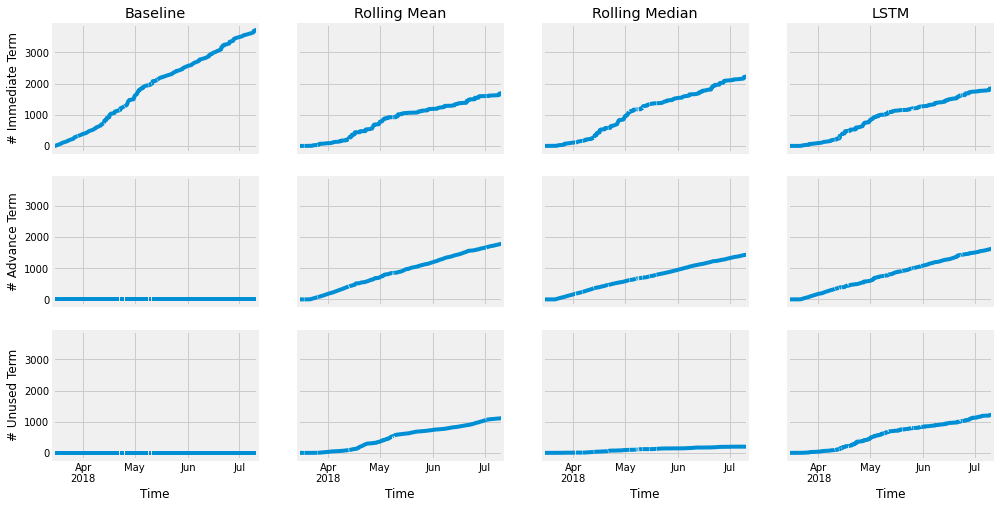

In [238]:
fig, axs = plt.subplots(3, 4, sharey=True, sharex=True, figsize=(15, 8))
titles = ['Baseline', 'Rolling Mean', 'Rolling Median', 'LSTM']
labels = ['Random', 'Least-Core-Used', 'Least-Resubmit', 'Recent-Deployed']
for i, pre in enumerate(predictors):
    for j, pol in enumerate(policies[3:]):
        work_dir = '%s/%s' % (pre, pol)
        
        node_term = process_node_terminations(work_dir)

        node_term['immediate termination'].resample('3H').mean().plot(label=labels[j], ax=axs[0][i])
        node_term['success termination'].resample('3H').mean().plot(label=labels[j], ax=axs[1][i])
        node_term['unused terminations'].resample('3H').mean().plot(label=labels[j], ax=axs[2][i])

        print(pre, pol, node_term.max())
    
    axs[0][i].set_ylabel('# Immediate Term')
    # axs[0][i].legend(loc='upper left')

    axs[1][i].set_ylabel('# Advance Term')
    # axs[1][i].legend(loc='upper left')

    axs[2][i].set_ylabel('# Unused Term')
    # axs[2][i].legend(loc='upper left')

axs[0][0].set_title(titles[0])
axs[0][1].set_title(titles[1])
axs[0][2].set_title(titles[2])
axs[0][3].set_title(titles[3])

# axs[0][0].legend(loc='upper left', bbox_to_anchor=(1.05, 0.3), loc='lower left', borderaxespad=0., fontsize=16)
# fig.suptitle('Node Terminations')
# plt.tight_layout()
plt.savefig('figs/exp3/terminations.png', dpi=500)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Library/Fram

1891.1419098143235
852.0285051375539


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Library/Fram

1094.0082863771959
923.8886310904873


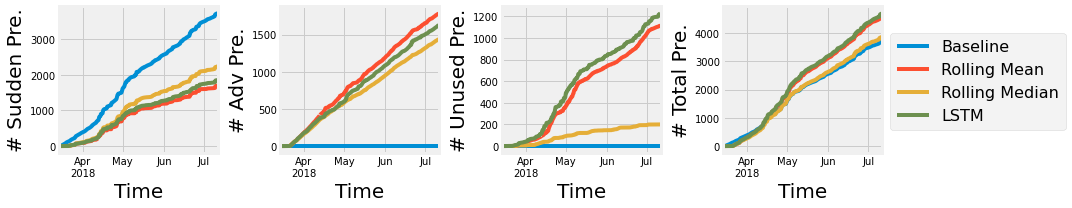

In [239]:
fig, axs = plt.subplots(1, 4,  sharex=True, figsize=(15, 3))
titles = ['Baseline', 'Rolling Mean', 'Rolling Median', 'LSTM']
labels = ['Random', 'Least-Core-Used', 'Least-Resubmit', 'Recent-Deployed']
for j, pol in enumerate(policies[3:]):
    for i, pre in enumerate(predictors):
        work_dir = '%s/%s' % (pre, pol)
        
        node_term = process_node_terminations(work_dir)
        node_term['immediate termination'].resample('6H').mean().plot(label=titles[i], ax=axs[0])
        print(node_term['immediate termination'].mean())
        node_term['success termination'].resample('6H').mean().plot(label=titles[i], ax=axs[1])
        node_term['unused terminations'].resample('6H').mean().plot(label=titles[i], ax=axs[2])
        (node_term['immediate termination'] + node_term['success termination'] + node_term['unused terminations']).resample('6H').mean().plot(label=titles[i], ax=axs[3])

    
axs[0].set_ylabel('# Sudden Pre.', fontsize=20)
axs[0].set_xlabel('Time', fontsize=20)

axs[1].set_ylabel('# Adv Pre.', fontsize=20)
axs[1].set_xlabel('Time', fontsize=20)

axs[2].set_ylabel('# Unused Pre.', fontsize=20)
axs[2].set_xlabel('Time', fontsize=20)

axs[3].set_ylabel('# Total Pre.', fontsize=20)
axs[3].set_xlabel('Time', fontsize=20)
axs[3].legend(loc='lower left', bbox_to_anchor=(1, 0.1), ncol=1, fontsize=16)

# fig.suptitle('Node Terminations')
plt.tight_layout()
plt.savefig('figs/exp3/terminations.png', dpi=3000)

In [240]:
temp = [1891.1419098143235, 852.0285051375539, 1094.0082863771959, 923.8886310904873]
temp = np.array(temp)
100 * (temp[1:] - temp[0])/temp[0]

array([-54.94634746, -42.15091524, -51.14652019])